# ETHD: Entangled Trajectories Hamiltonian Dynamics methods (experimental). 1D models

## Table of Content <a name="TOC"></a>

1. [General setups](#1)

2. [Models](2)
   
3. [Dynamics script](#3)

4. [Calculations](#4)

  4.1. [Model 2, Verlet](#4.1)
  
  4.2. [Model 2, ETHD](#4.2)
  
  4.3. [Model 2, ETHD3](#4.3) 
  
  4.4. [Model 2, ETHD3 with momentum](#4.4) 
  

## A. Learning objectives

- to 
- to visualize 1D and 2D properties of Gaussian wavepackets
- to predict how computed properties depend on parameters of the Gaussian wavepacket
- to be able to tell the difference between quantum and classical kinetic energies of a Gaussian wavepacket
- to argument the conceptual flaw of considering classical particles as a zero-width limit of Gaussian wavepackets

## B. Use cases

- [Entangling trajectories via ETHD](#entangling)
- [Plotting properties from trajectory-based calculations](#plotting_props)


## C. Functions

- `liblibra::libdyn::libgwp`
  - [`gwp_coupling`](#gwp_coupling_function)    
  - [`gwp_dipole`](#gwp_dipole_function)
  - [`gwp_kinetic`](#gwp_kinetic_function)
  - [`gwp_overlap`](#gwp_overlap_function)
  - [`gwp_value`](#gwp_value)
    
- `libra_py`
  - `data_visualize`
   - [`plot_map`](#plot_map)      

## D. Classes and class members
    
    None

## 1. General setups
<a name="setups"></a>[Back to TOC](#TOC)

First, lets import all the necessary libraries and define all the variables that we may need

In [3]:
import cmath
import math
import os
import sys
import time


from liblibra_core import *

from libra_py import units
import libra_py.dynamics.tsh.compute as compute
import libra_py.dynamics.tsh.save as save
import libra_py.dynamics.tsh.plot as plot
import util.libutil as comn


import matplotlib.pyplot as plt 
import h5py

%matplotlib inline 

Also, lets import matplotlib for plotting and define all the plotting parameters: sizes, colors, etc.

## 2. Models
<a name="gwp_value"></a><a name="plotting_gwp"></a>[Back to TOC](#TOC)


In [8]:
class tmp:
    pass    

def model1(q, params, full_id):
    """
    Hdia = 0.5*k*x^2   
    Sdia =  1.0
    Ddia  = 0.0

    """

    Hdia = CMATRIX(1,1)
    Sdia = CMATRIX(1,1)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(1,1) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(1,1) )
  
    
    indx = full_id[-1]
    x = q.get(0, indx)
    x0,k,D,V = params["x0"], params["k"], params["D"], params["V"]

    Hdia.set(0,0, k*x*x*(1.0+0.0j) )
    Sdia.set(0,0, 1.0+0.0j)

    for i in [0]:
        #  d Hdia / dR_0
        d1ham_dia[i].set(0,0, 2.0*k*x*(1.0+0.0j) )

        #  <dia| d/dR_0| dia >
        dc1_dia[i].set(0,0, 0.0+0.0j)


    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.dc1_dia = dc1_dia

    return obj
    


def model2(q, params, full_id):
    """
    Symmetric Double Well Potential
    Hdia = 0.25*q^4 - 0.5*q^2   
    Sdia = 1.0
    Ddia = 0.0
    """

    Id = Cpp2Py(full_id)
    indx = Id[-1]

    Hdia = CMATRIX(1,1)
    Sdia = CMATRIX(1,1)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(1,1) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(1,1) )

    x = q.col(indx).get(0)
    x2 = x*x

    Hdia.set(0,0, (0.25*x2*x2 - 0.5*x2)*(1.0+0.0j) )
    Sdia.set(0,0, 1.0+0.0j)

    for i in [0]:
        #  d Hdia / dR_0
        d1ham_dia[i].set(0,0, x*(x2 - 1.0)*(1.0+0.0j) )

        #  <dia| d/dR_0| dia >
        dc1_dia[i].set(0,0, 0.0+0.0j)


    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.dc1_dia = dc1_dia

    return obj



def compute_model(q, params, full_id):

    model = params["model"]
    res = None

    if model==1:
        res = model1(q, params, full_id)
    
    elif model==2:
        res = model2(q, params, full_id)

    return res
    


## 3. Dynamics script
<a name="gwp_value"></a><a name="plotting_gwp"></a>[Back to TOC](#TOC)


The calculation script

In [9]:
def run_tsh(common_params, model_params, prefix):
        
    params = dict(common_params)
           
    # Random numbers generator object
    rnd = Random()
    
    #============ Initialize dynamical variables ==================
    x0 = params["x0"]
    p0 = params["p0"]
    masses = params["masses"]
    k0     = params["k"]
    ndofs  = len(x0)
    ntraj  = params["ntraj"]
    nstates = params["nstates"]
 
    # Nuclear
    init_nucl = {"init_type":2, "force_constant":k0, "ntraj":ntraj}
    q, p, iM = compute.init_nuclear_dyn_var(x0, p0, masses, init_nucl, rnd)
    
    # Electronic
    istate = params["istate"]
    istates = []
    for i in range(nstates):
        istates.append(0.0)
    istates[ istate[1] ] = 1.0    
    _init_elec = { "init_type":0, "nstates":nstates, "istates":istates, "rep":istate[0],  "ntraj":ntraj   }

    
    #============= Dynamical variables ==============
    DR = MATRIX(nstates,nstates)
    AG = MATRIX(nstates,nstates)


    properties_to_save = [ "timestep", "time", "Ekin_ave", "Epot_ave", "Etot_ave", "Etherm", "E_NHC", 
                          "dEkin_ave", "dEpot_ave", "dEtot_ave", "states", "SH_pop", "SH_pop_raw",
                           "D_adi", "D_adi_raw", "D_dia", "D_dia_raw", "q", "p", "Cadi", "Cdia", 
                           "hvib_adi", "hvib_dia", "St", "basis_transform", "projector"
                        ]         
    
    dyn_params = dict(common_params)
    
    # This should update only the properties that aren't defined, but not override the existing values!
    critical_params = [  ] 
    default_params = { "rep_tdse":1, "rep_ham":0, "rep_sh":1, "rep_lz":0, "tsh_method":-1,
                       "force_method":1, "nac_update_method":1, "rep_force":1,
                       "hop_acceptance_algo":20, "momenta_rescaling_algo":201,
                       "use_boltz_factor":0, "Temperature":300.0, "do_reverse":1, "vel_rescale_opt":-1,
                  
                       "do_phase_correction":0, "tol":1e-3,                  
                       "state_tracking_algo":0, "MK_alpha":0.0, "MK_verbosity":0, 
                                 
                       "entanglement_opt":0, "ETHD3_alpha":0.0, "ETHD3_beta":0.0, 
                       "decoherence_algo":-1, "decoherence_rates":DR,
                       "decoherence_times_type":-1, "decoherence_C_param":1.0, 
                       "decoherence_eps_param":0.1, "dephasing_informed":0,
                       "ave_gaps":AG, "instantaneous_decoherence_variant":1, "collapse_option":0,

                       "ensemble":0, "thermostat_params":{ "thermostat_type":"Nose-Hoover", "Temperature":300.0,
                                         "NHC_size":5, "nu_therm":0.01 },
                      
                       "hdf5_output_level":-1, "prefix":prefix, "use_compression":0, "compression_level":[0,0,0], 
                       "mem_output_level":4, "txt_output_level":0, "properties_to_save": properties_to_save,
                      
                       "which_adi_states":[0], "which_dia_states":[0],  
                       "is_nbra":0,                      
                       "prefix":prefix,
                 } 


    comn.check_input(dyn_params, default_params, critical_params)
            
    _model_params = dict(model_params)
    _model_params.update({"model0": model_params["model"] })
    
    start = time.time()                               
    res = compute.generic_recipe(q, p, iM, dyn_params, compute_model, _model_params, _init_elec, rnd)
    end = time.time()    
    print(F"Calculation time = {end - start} seconds")
    
    
    return res 


The plotting script

In [10]:
def plot_all(which_traj, prefix):

    plt_params = plot.common_defaults({ "which_trajectories": which_traj })

    f = h5py.File(F"{prefix}/mem_data.hdf", "r")

    plt.figure(1)
    plot.add_energies(plt, f, plt_params, "energies")
    #plt.savefig("energies.png")
    plt.show()

    plt_params.update({ "no_label":1 })
    plt.figure(2)
    plot.add_trajectory_resolved_ham_property(plt, f, plt_params, "hvib_adi" )
    #plt.savefig("ham.png")
    plt.show()
    
    plt.figure(3)
    plot.add_cooordinates_vs_t(plt, f, plt_params)
    #plt.savefig("q-t.png")
    plt.show()
    
    plt.figure(4)
    plot.add_phase_space(plt, f, plt_params)
    #plt.savefig("q-p.png")
    plt.show()

    f.close()

## 4. Calculations
<a name="gwp_value"></a><a name="plotting_gwp"></a>[Back to TOC](#TOC)


### 4.1. Model 2. Verlet

 step= 0
 step= 500
 step= 1000
 step= 1500
 step= 2000
 step= 2500
 step= 3000
 step= 3500
 step= 4000
 step= 4500
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'Etherm', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'Etherm', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basi

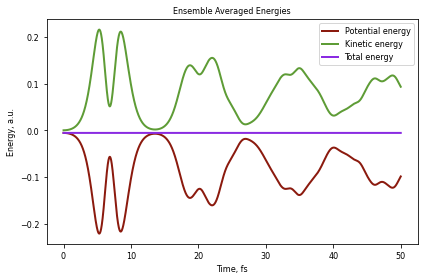

/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex val

/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


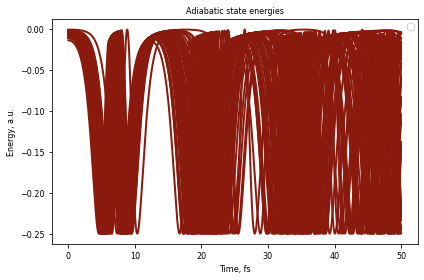

No handles with labels found to put in legend.


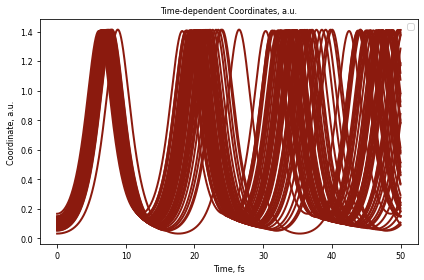

No handles with labels found to put in legend.


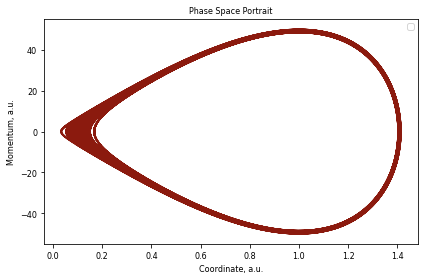

In [18]:
prefix = "model2-verlet"

dyn_params = { "ntraj":50, "nsteps":5000, "dt":0.01*units.fs2au, 
               "nstates":1, "istate":[1, 0],   
               "x0":[0.1], "p0":[0.0],  "masses":[5000],  "k":[100.0],
             } 

dyn_params.update({ "entanglement_opt": 0 })
#dyn_params.update({ "entanglement_opt": 1 })
#dyn_params.update({ "entanglement_opt": 2, "ETHD3_alpha":5.1 })
#dyn_params.update({ "entanglement_opt": 22, "ETHD3_alpha":5.1, "ETHD3_beta":5.0 })


# Make a dictionary for the model specific parameters
model_params = { "x0":1.0, "k":0.05, "D":-0.1, "V":0.05, "omega":0.25, "model":2 }

res = run_tsh(dyn_params, model_params, prefix)

which_traj = list(range(50)) 
plot_all(which_traj, prefix)

### 4.2. Model 2. ETHD

 step= 0
 step= 500
 step= 1000
 step= 1500
 step= 2000
 step= 2500
 step= 3000
 step= 3500
 step= 4000
 step= 4500
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'Etherm', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'Etherm', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basi

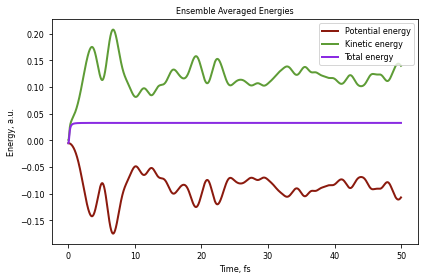

/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex val

/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


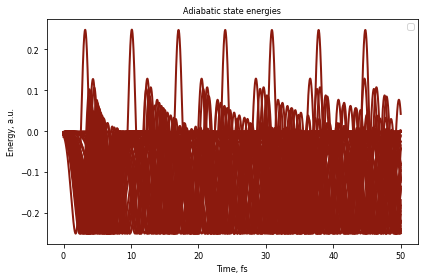

No handles with labels found to put in legend.


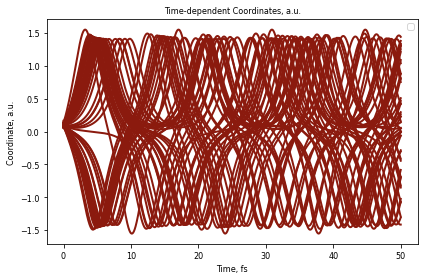

No handles with labels found to put in legend.


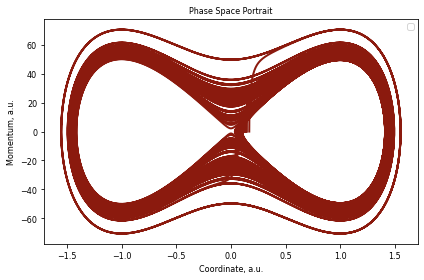

In [17]:
prefix = "model2-ethd"

dyn_params = { "ntraj":50, "nsteps":5000, "dt":0.01*units.fs2au, 
               "nstates":1, "istate":[1, 0],   
               "x0":[0.1], "p0":[0.0],  "masses":[5000],  "k":[100.0],
             } 

#dyn_params.update({ "entanglement_opt": 0 })
dyn_params.update({ "entanglement_opt": 1 })
#dyn_params.update({ "entanglement_opt": 2, "ETHD3_alpha":5.1 })
#dyn_params.update({ "entanglement_opt": 22, "ETHD3_alpha":5.1, "ETHD3_beta":5.0 })


# Make a dictionary for the model specific parameters
model_params = { "x0":1.0, "k":0.05, "D":-0.1, "V":0.05, "omega":0.25, "model":2 }

res = run_tsh(dyn_params, model_params, prefix)

which_traj = list(range(50)) 
plot_all(which_traj, prefix)

### 4.3. Model 2. ETHD3

 step= 0
 step= 500
 step= 1000
 step= 1500
 step= 2000
 step= 2500
 step= 3000
 step= 3500
 step= 4000
 step= 4500
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'Etherm', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'Etherm', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basi

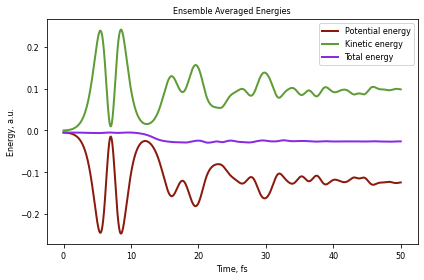

/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex val

/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex val

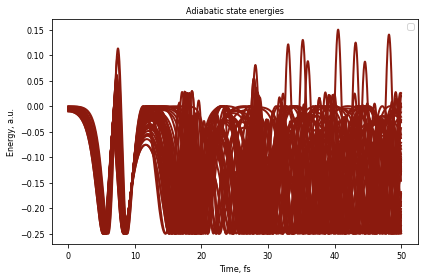

No handles with labels found to put in legend.


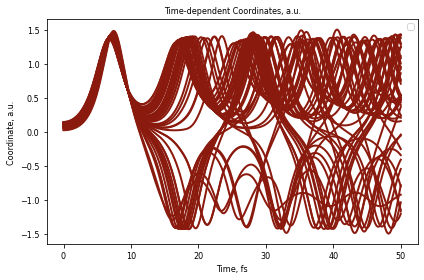

No handles with labels found to put in legend.


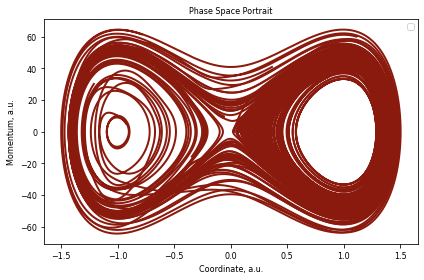

In [16]:
prefix = "model2-ethd3"

dyn_params = { "ntraj":50, "nsteps":5000, "dt":0.01*units.fs2au, 
               "nstates":1, "istate":[1, 0],   
               "x0":[0.1], "p0":[0.0],  "masses":[5000],  "k":[100.0],
             } 

#dyn_params.update({ "entanglement_opt": 0 })
#dyn_params.update({ "entanglement_opt": 1 })
dyn_params.update({ "entanglement_opt": 2, "ETHD3_alpha":5.1 })
#dyn_params.update({ "entanglement_opt": 22, "ETHD3_alpha":5.1, "ETHD3_beta":5.0 })


# Make a dictionary for the model specific parameters
model_params = { "x0":1.0, "k":0.05, "D":-0.1, "V":0.05, "omega":0.25, "model":2 }

res = run_tsh(dyn_params, model_params, prefix)

which_traj = list(range(50)) 
plot_all(which_traj, prefix)

### 4.4. Model 2. ETHD3, with momentum

 step= 0
 step= 500
 step= 1000
 step= 1500
 step= 2000
 step= 2500
 step= 3000
 step= 3500
 step= 4000
 step= 4500
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'Etherm', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'Etherm', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basi

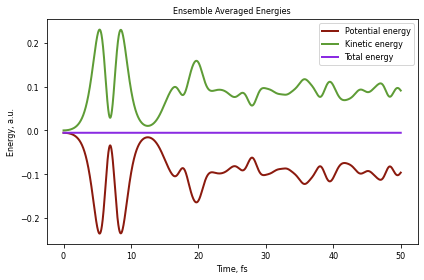

/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex val

/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


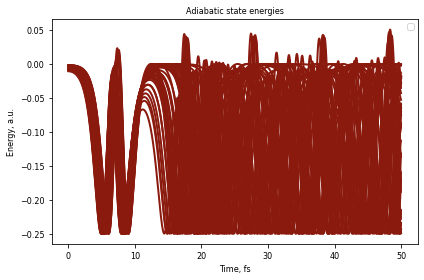

No handles with labels found to put in legend.


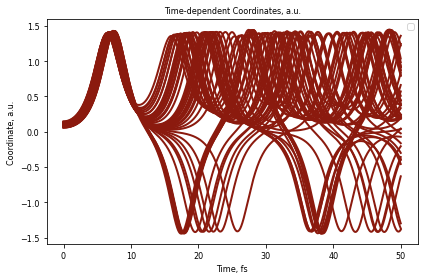

No handles with labels found to put in legend.


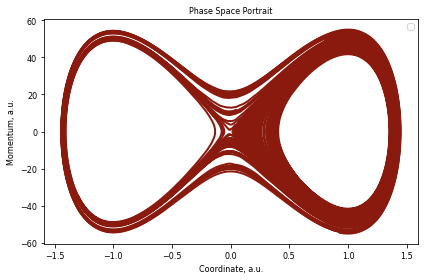

In [15]:
prefix = "model2-ethd3-new"

dyn_params = { "ntraj":50, "nsteps":5000, "dt":0.01*units.fs2au, 
               "nstates":1, "istate":[1, 0],   
               "x0":[0.1], "p0":[0.0],  "masses":[5000],  "k":[100.0],
             } 

#dyn_params.update({ "entanglement_opt": 0 })
#dyn_params.update({ "entanglement_opt": 1 })
#dyn_params.update({ "entanglement_opt": 2, "ETHD3_alpha":5.1 })
dyn_params.update({ "entanglement_opt": 22, "ETHD3_alpha":5.1, "ETHD3_beta":5.0 })


# Make a dictionary for the model specific parameters
model_params = { "x0":1.0, "k":0.05, "D":-0.1, "V":0.05, "omega":0.25, "model":2 }

res = run_tsh(dyn_params, model_params, prefix)

which_traj = list(range(50)) 
plot_all(which_traj, prefix)